In [21]:
import sys
sys.path.append("../")
from synthetic import DataGenerator, SynthSettings, extract_lines_cc
from noise_designer import load_batches
import matplotlib.pyplot as plt
import random
import numpy as np

In [14]:
pool = {i for i in range(5)}
level = random.choice(list(pool))
iterator = load_batches(level=0)

In [15]:
characters,scrolls,line_masks = next(iterator)

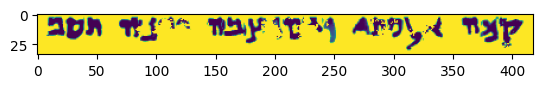

In [80]:
lines = extract_lines_cc(scrolls[0], line_masks[0])
line1 = lines[0]
plt.imshow(line1)

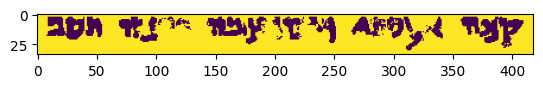

In [81]:
def get_quantile_2d(raw_mask: np.ndarray, q: float = 0.8) -> np.ndarray:
    """
    raw_mask shape (H,W)
    """
    threshold_value = np.quantile(raw_mask, q)
    mask = (raw_mask >= threshold_value).astype(np.uint8)
    return mask

plt.imshow(get_quantile_2d(line1))

In [82]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def show_line_with_boxes_contours_centers(line1, ctrs, boxes, figsize=(8, 6)):
 
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(line1, cmap='gray' if line1.ndim == 2 else None)

    center_xs = []

    # Draw bounding boxes and centre markers
    for (minr, minc, maxr, maxc) in boxes:
        # Bounding box
        rect = Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            edgecolor='blue',
            facecolor='none',
            linewidth=1,
        )
        ax.add_patch(rect)

        # Centre of the box
        cx = (minc + maxc) // 2
        cy = (minr + maxr) // 2
        center_xs.append(cx)
        ax.plot(cx, cy, marker='+', markersize=8, markeredgewidth=1.5,
                markeredgecolor='lime', markerfacecolor='none')

    # Draw contours
    for c in ctrs:
        ax.plot(c[:, 1], c[:, 0], '-r', lw=1)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    return center_xs



In [83]:
from skimage import filters, measure, morphology, draw, color
from skimage.filters import sobel
from skimage.segmentation import morphological_geodesic_active_contour, watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle


def split_region_into_letters(label_img, region, min_dist=5):
    """Watershed‐split one regionprop into multiple RegionProps if needed."""
    minr, minc, maxr, maxc = region.bbox
    mask = (label_img[minr:maxr, minc:maxc] == region.label)

    dist = ndi.distance_transform_edt(mask)
    coords = peak_local_max(dist, min_distance=min_dist, labels=mask)
    local_max = np.zeros_like(mask, dtype=bool)
    if coords.shape[0] > 0:
        local_max[coords[:, 0], coords[:, 1]] = True
    markers, _ = ndi.label(local_max)
    ws = watershed(-dist, markers, mask=mask)

    new_regions = []
    for lbl in np.unique(ws):
        if lbl == 0:
            continue
        sub_full = np.zeros_like(label_img, dtype=int)
        sub_full[minr:maxr, minc:maxc][ws == lbl] = 1
        props = measure.regionprops(sub_full)
        if props:
            new_regions.append(props[0])
    return new_regions

def segment_contours_and_boxes(img, disk_radius, mgac_iter, smoothing, balloon, pad,
                               aspect_thresh=1.5, area_thresh=1000):
    """Run MGAC per-region and return padded bboxes (with watershed splitting). Morphological Geodesical Active Contours"""
    gray = img.astype(float) if img.ndim < 3 else color.rgb2gray(img)
    blur = filters.gaussian(gray, sigma=1)
    thr = filters.threshold_otsu(blur)
    clean = morphology.remove_small_objects(blur < thr, min_size=30)
    lbls = measure.label(clean)
    raw_regions = measure.regionprops(lbls)
    phi = 1.0 / (1.0 + sobel(blur))

    # collect final regions (split if needed)
    regions = []
    for r in raw_regions:
        h = r.bbox[2] - r.bbox[0]
        w = r.bbox[3] - r.bbox[1]
        if (w / h > aspect_thresh) or ((w * h) > area_thresh):
            split_regions = split_region_into_letters(lbls, r, min_dist=int(h / 2))
            if len(split_regions) >= 2:
                regions.extend(split_regions)
            else:
                regions.append(r)  
        else:
            regions.append(r)

    contours = []
    boxes = []

    for r in regions:
        minr, minc, maxr, maxc = r.bbox[:4]
        minr = max(minr - pad, 0)
        minc = max(minc - pad, 0)
        maxr = min(maxr + pad, gray.shape[0])
        maxc = min(maxc + pad, gray.shape[1])
        boxes.append((minr, minc, maxr, maxc))

        sub_phi = phi[minr:maxr, minc:maxc]
        init_ls = np.zeros_like(sub_phi, dtype=np.int8)
        cy = int(r.centroid[0] - minr)
        cx = int(r.centroid[1] - minc)
        rr, cc = draw.disk((cy, cx), radius=disk_radius, shape=sub_phi.shape)
        init_ls[rr, cc] = 1

        ls_sub = morphological_geodesic_active_contour(
            sub_phi,
            num_iter=mgac_iter,
            init_level_set=init_ls,
            smoothing=smoothing,
            balloon=balloon
        )
        ctrs = measure.find_contours(ls_sub, 0.5)
        if ctrs:
            c = max(ctrs, key=len) + np.array([minr, minc])
            contours.append(c)

    return contours, boxes


ctrs, boxes = segment_contours_and_boxes(
    line1,
    disk_radius=1,
    mgac_iter=200,
    smoothing=0,
    balloon=0.75,
    pad=5
)

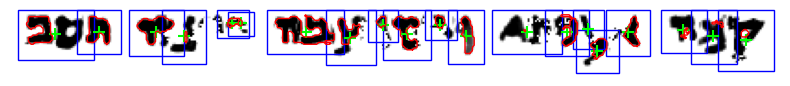

X-coordinates of centres: [24, 48, 79, 160, 202, 233, 280, 313, 365, 94, 184, 215, 247, 302, 335, 399, 120, 125, 381, 318]


In [84]:
x_coords = show_line_with_boxes_contours_centers(line1, ctrs, boxes)
print("X-coordinates of centres:", x_coords)

In [ ]:
#Given 27 channels ( images)
#Extract x position of the letters for the channel 
#Save them as dictionary, [letter][[coord1],[coord2],...]